In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator as PcygniCalculator_old
from pcygni_5_Spec_Rel import PcygniCalculator

import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB4'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[3]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

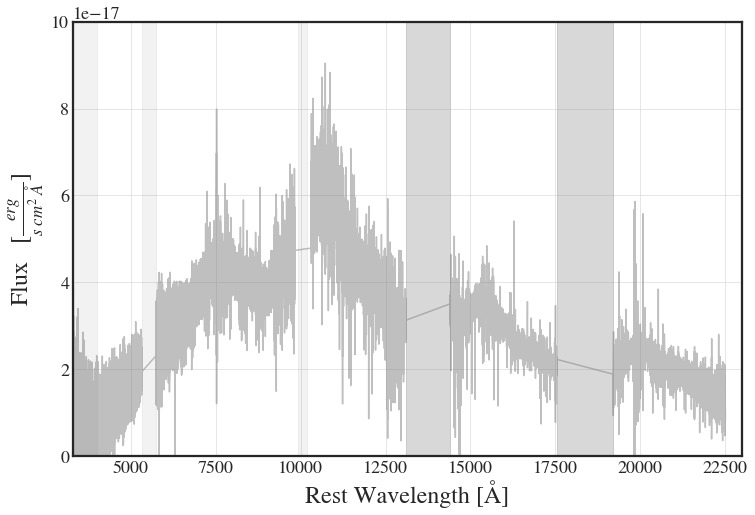

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 1e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [6]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, #amp3 =2 , cen3 = 12200, sig3 = 250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau3 = gaussian(wav, 1e-17*amp3, cen3, sig3)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2#+gau3


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    #amp3, cen3, sig3 = v["amp3"], v["cen3"], v["sig3"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    #, amp3 =amp3, cen3 = cen3, sig3 = sig3)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [7]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

In [8]:
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #, tau2 = 0.1, lam2=7000): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)

    #pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)

    
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction#*pcyg_prof_novel
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    #tau2, lam2 = v["tau2"], v["lam2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)#, tau2=tau2, lam2=lam2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

#### Fit structure

In [9]:
pickle_in = open("./data/OB4/OB4_3_peaks_with_gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p

name,value,standard error,relative error,initial value,min,max,vary
T,3229.35669,1.86202876,(0.06%),3217.819292907171,2500.00000,7500.00000,True
N,3.1295e-29,1.0755e-31,(0.34%),3.2010461509524127e-29,-inf,inf,True
vphot,0.17252132,5.2321e-04,(0.30%),0.17304530867385287,0.00000000,1.00000000,True
vmax,0.22791806,4.0757e-04,(0.18%),0.2275609224257,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.36046558,0.00550567,(1.53%),0.38361520428160834,0.00000000,10.0000000,True
vref,0.00000000,,(1.53%),0.0,0.00000000,1.00000000,False
ve,7.96269664,1.77601098,(22.30%),7.104226961196531,0.00000000,10.0000000,True
occult,8.15231253,0.10853579,(1.33%),7.656267982349197,0.10000000,20.0000000,True
amp1,0.96206669,0.00545736,(0.57%),0.9278409771344276,0.01000000,5.00000000,True


In [10]:
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
mi2.params

name,value,initial value,min,max,vary
T,3235.73723,3229.356686107796,2500.00000,7500.00000,True
N,3.0317e-29,3.129516127585633e-29,-inf,inf,True
vphot,0.17377175,0.17252131613287214,0.00000000,1.00000000,True
vmax,0.22724113,0.22791806227961445,0.00000000,1.00000000,True
t0,385200.000,385200,-inf,inf,False
tau,0.31901584,0.3604655837654193,0.00000000,10.0000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,7.96906509,7.962696640917995,0.00000000,10.0000000,True
occult,8.08213938,8.152312527615196,0.10000000,20.0000000,True
amp1,0.98800554,0.9620666898149263,0.01000000,5.00000000,True


In [11]:
p=mi2.params

In [12]:
#pickle_in = open("./data/OB2/Rel_5.pkl","rb") #OB1_3_peaks_100walkers
#emcee_res = pickle.load(pickle_in)
#p = emcee_res.params
#p['occult'].vary=False #p['occult'].value=1

mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 30 #v = p.valuesdict()
res4 = mini.emcee(nwalkers=nwalkers, burn=0, steps=500, thin=1, params=p, seed=12, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 500/500 [11:23<00:00,  1.37s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [71.37073453 70.84907149 40.95805218 47.69552644 29.50362496 64.6271565
 49.59611325 67.61563279 56.64973453 32.14956481 48.96820425 42.82321512
 64.80052756]
Time elapsed [hours]: 0.1903885042005115


name,value,standard error,relative error,initial value,min,max,vary
T,3249.85442,8.62826294,(0.27%),3235.7372284384082,2500.00000,7500.00000,True
N,2.9657e-29,4.2391e-31,(1.43%),3.031664375925047e-29,-inf,inf,True
vphot,0.17573287,0.00125844,(0.72%),0.17377174783451566,0.00000000,1.00000000,True
vmax,0.23006621,0.00175901,(0.76%),0.2272411284677427,0.00000000,1.00000000,True
t0,385200.000,,(0.76%),385200,-inf,inf,False
tau,0.31974643,0.00501837,(1.57%),0.3190158364305351,0.00000000,10.0000000,True
vref,0.00000000,,(1.57%),0.0,0.00000000,1.00000000,False
ve,8.12391265,0.23351451,(2.87%),7.969065086935433,0.00000000,10.0000000,True
occult,7.97530351,0.14502301,(1.82%),8.082139380287831,0.10000000,20.0000000,True
amp1,1.01502881,0.02128255,(2.10%),0.9880055422744393,0.01000000,5.00000000,True


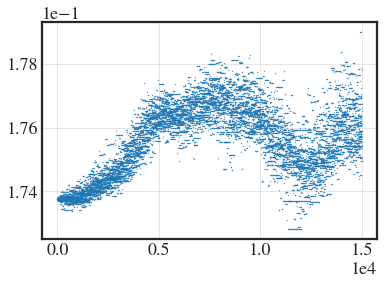

In [13]:
plt.scatter( np.arange(len(res4.flatchain['vphot'])), res4.flatchain['vphot'], s=0.1)
np.mean(res4.flatchain['vphot']), np.std(res4.flatchain['vphot'])  
res4.params

In [14]:
file = "./Data/OB4/Rel_3.pkl"
with open(file, 'wb') as outfile:
    pickle.dump(res4, outfile)